In [1]:
# Numpy
import numpy as np

# OS
import os

# Pytorch related libraries
import torch # for pytorch
import torch.nn as nn # for Core neural network class in pytorch
import torch.optim as optim # for using the inbuilt pytorch optimzation functions
from torch.autograd import Variable 
import torch.nn.functional as F #for using different inbuilt functions of pytorch

# Torchvision
import torchvision 
from torchvision import datasets # for various datasets
import torchvision.transforms as transforms # for dataset transformation

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 # for image manipulation

# cpickle
import _pickle as cPickle

# Set random seed for reproducibility
SEED = 21
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Preprocessing and transforming data

In [2]:
data_transform = transforms.Compose([transforms.RandomHorizontalFlip()
                                      ,transforms.RandomRotation(10)
                                      ,transforms.ToTensor()
                                     ])

In [3]:
batch_size_num = 64

In [4]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size_num,num_workers=0)

Files already downloaded and verified


In [5]:
len(dataset)

50000

In [6]:
def calculate_img_stats(loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for imgs,_ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean,std

In [7]:
cifar10_mean,cifar10_std = calculate_img_stats(loader) # Note : only calculated on train dataset as will be simialr for test set

In [8]:
print(cifar10_mean,cifar10_std)

tensor([ 0.4735,  0.4640,  0.4295]) tensor([ 0.2200,  0.2165,  0.2151])


In [9]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(cifar10_mean, cifar10_std)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(cifar10_mean, cifar10_std)
                                    ])

In [10]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
trainset.train_data.shape

(50000, 32, 32, 3)

In [12]:
def load_classes():
    path = './data/cifar-10-batches-py/'
    file = 'batches.meta'
    
    with open(path + file, 'rb') as fin:
        dict = cPickle.load(fin)
        print(dict)
        return dict['label_names']

def print_classes(label_names):
    for i in range(10):
        print(str(i) + " : " + label_names[i])

classes = load_classes()
print_classes(classes)

{'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072, 'num_cases_per_batch': 10000}
0 : airplane
1 : automobile
2 : bird
3 : cat
4 : deer
5 : dog
6 : frog
7 : horse
8 : ship
9 : truck


In [13]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

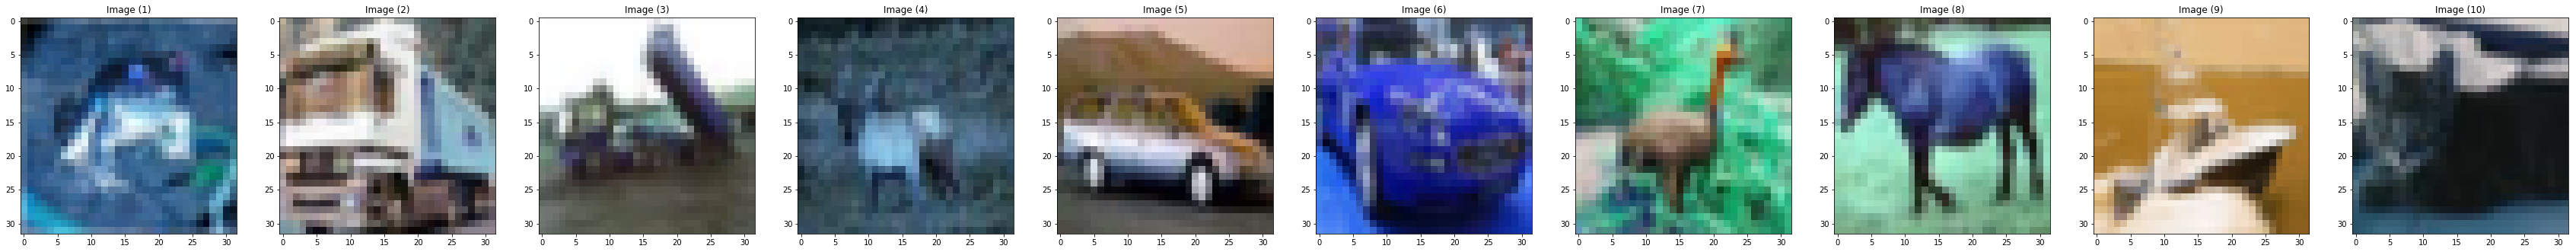

In [14]:
show_images(trainset.train_data[0:10])

In [49]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_num,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

# Define the Autoencoder model

In [38]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # batch_size : 64
        # Input size to the Autoencoder : [batch_size, 3, 32, 32]
        # Output size from the Autoencoder : [batch_size, 3, 32, 32]
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 3x3 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride=1, padding=1), # Output size : [batch_size, 24, 32, 32]
            nn.ReLU(),
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, stride=2, padding=1), # Output size : [batch_size, 48, 16, 16]
            
        )
        self.decoder = nn.Sequential(
            # For Upscaling :
            # 2x2 kernels can only learn nearest pixel upscaling.
            # 3x3 kernels can do bilinear but will require asymmetric padding.
            # But 4x4 can do bilinear again without asymmetrical padding.
          
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 32, 32]
            nn.ReLU(),  #TODO : try with LeakyReLU while decoding
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=1), # Output size: [batch_size, 12, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 3, stride=1, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define the train method and start training

In [39]:
# moves variables to CUDA
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [40]:
def train(model, num_epochs=5, batch_size=batch_size_num, learning_rate=1e-3):
 
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
    
    outputs_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = get_torch_vars(inputs)

            # ============ Forward ============
            encoded, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            # ============ Backward ============
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs_store.append((epoch, inputs, outputs),)

    print('Finished Training')
    print('Saving Model...')
    if not os.path.exists('./weights'):
        os.mkdir('./weights')
    torch.save(model.state_dict(), "./weights/autoencoder_16*16.pkl")
    return outputs

In [41]:
def create_model():
    autoencoder = Autoencoder()
    desc_model(autoencoder.encoder, autoencoder.decoder)
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU.")
    return autoencoder

In [42]:
def desc_model(encoder, decoder):
    print("==================== Encoder Network ====================")
    print(encoder)
    print("==================== Decoder Network ====================")
    print(decoder)
    print("\n")

In [43]:
# Create model
autoencoder = create_model()

#train
max_epochs = 100
outputs = train(autoencoder, max_epochs)

==================== Encoder Network ====================
Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)
==================== Decoder Network ====================
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Sigmoid()
)


Model moved to GPU.
Epoch:1, Loss:0.8401
Epoch:2, Loss:1.0056
Epoch:3, Loss:0.7173
Epoch:4, Loss:0.7093
Epoch:5, Loss:0.7552
Epoch:6, Loss:0.8635
Epoch:7, Loss:0.7572
Epoch:8, Loss:0.9590
Epoch:9, Loss:1.1580
Epoch:10, Loss:0.8998
Epoch:11, Loss:0.6794
Epoch:12, Loss:0.6477
Epoch:13, Loss:1.0175
Epoch:14, Loss:0.7755

In [44]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Loading checkpoint...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship airplane


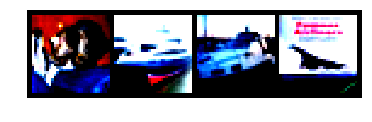

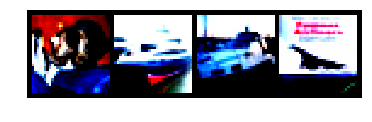

In [51]:
print("Loading checkpoint...")
autoencoder.load_state_dict(torch.load("./weights/autoencoder_16*16.pkl"))
dataiter = iter(testloader)
images, labels = dataiter.next()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images.cuda())

encodings, decoded_imgs = autoencoder(images)
imshow(torchvision.utils.make_grid(decoded_imgs.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    dog  bird  deer airplane


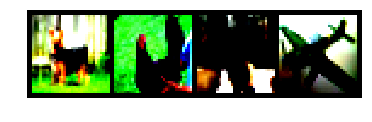

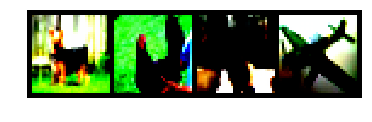

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  truck  frog  frog   dog


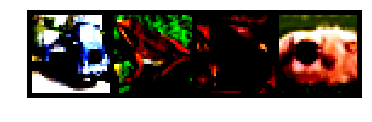

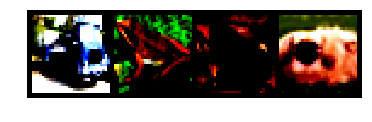

GroundTruth:   deer   dog truck  bird


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


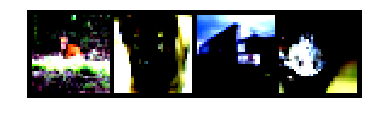

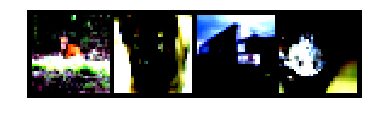

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   deer automobile truck   dog


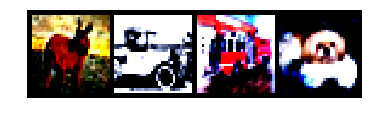

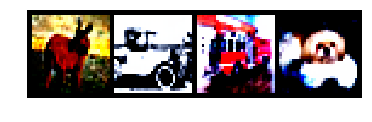

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:   deer  frog   dog  frog


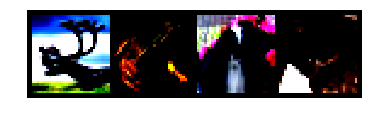

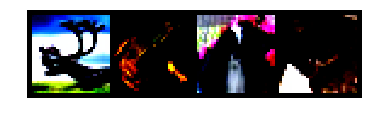

In [53]:
# Plot some five set of reconstructions
for i in range(5):
    images, labels = dataiter.next()
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    imshow(torchvision.utils.make_grid(images))

    images = Variable(images.cuda())

    decoded_imgs = autoencoder(images)[1]
    imshow(torchvision.utils.make_grid(decoded_imgs.data))